# 🤒 Epidemic mitigation project - environment tutorial

## Installing the environment

1. Install conda
2. Create a dedicated environment
3. Install from requirements.txt
4. Run a test

In [36]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env import Env
from epidemic_env.dynamics import ModelDynamics # why is this needed?
from epidemic_env.visualize import Visualize
%matplotlib inline

Content of the obs dict : dict_keys(['total', 'city', 'pop'])
obs['total'] : {'infected': [8, 31, 22, 122, 137, 89, 57], 'dead': [0, 0, 0, 0, 0, 0, 1]}
obs['city']['Lausanne'] : {'infected': [8, 31, 22, 122, 137, 89, 57], 'dead': [0, 0, 0, 0, 0, 0, 1]}
obs['pop'] : {'Lausanne': 295000, 'Geneva': 900000, 'Sion': 34978, 'Neuchâtel': 44531, 'Basel': 830000, 'Bern': 133115, 'Lücern': 82000, 'St-Gallen': 76213, 'Zürich': 1354000}


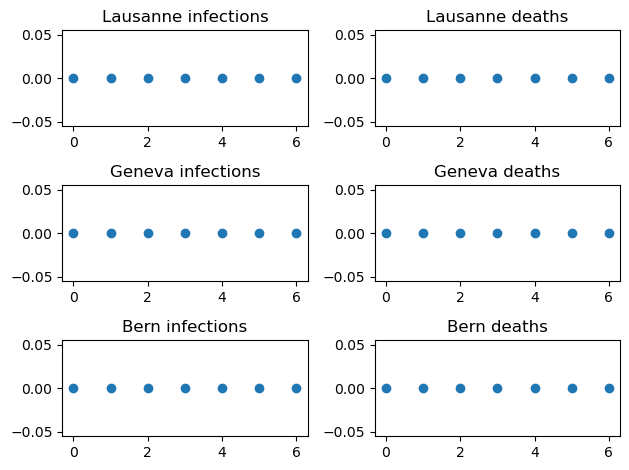

In [104]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment"""
env = Env(  dyn,
            action_space=None,
            observation_space=None,
            )

action = None # Do nothing

""" Run the simulation """
finished = False
obs, info = env.reset()
print(f"Content of the obs dict : {obs.keys()}")
print(f"obs['total'] : {obs['total']}") # contains the infected and death counts for each day of the week (for the entire country)
print(f"obs['city']['Lausanne'] : {obs['total']}") # contains same information as obs['total'] per in a per-city basis
print(f"obs['pop'] : {obs['pop']}") # contains the population (deaths are note removed) of each city (this is useful for normalization)


fig, ax = plt.subplots(3,2) # TODO : define a cuter plotting routine
ax[0,0].scatter(range(7),obs['city']['infected']['Lausanne'])
ax[0,0].set_title('Lausanne infections')
ax[0,1].scatter(range(7),obs['city']['dead']['Lausanne'])
ax[0,1].set_title('Lausanne deaths')
ax[1,0].scatter(range(7),obs['city']['infected']['Geneva'])
ax[1,0].set_title('Geneva infections')
ax[1,1].scatter(range(7),obs['city']['dead']['Geneva'])
ax[1,1].set_title('Geneva deaths')
ax[2,0].scatter(range(7),obs['city']['infected']['Bern'])
ax[2,0].set_title('Bern infections')
ax[2,1].scatter(range(7),obs['city']['dead']['Bern'])
ax[2,1].set_title('Bern deaths')
fig.tight_layout()
plt.show()

In [106]:
env.render()

Epidemic state : 
   - dead: 1
   - infected: 268


### The observation dict

At each time step the environment returns an observation in the form of a dictionnary stuctured as follows. This is the dictionnary of informations that can be used by the environment.
```python
obs = {
    'total': { # country-wide measurements (for each day of the week)
        'infected': [0, 79, 204,... # infected people
        'dead': [0, 0, 1, ... # dead people
    },
    'city': { # per-city measurements (for each day of the week)
        'infected': {
            'Lausanne': [0, 79, 198, ... # infected people
            'Geneva': [0, 0, 0, .. # dead people
        },
        'dead': {
            'Lausanne': [0, 0, 1, ... # infected people
            'Geneva': [0, 0, 0, .. # dead people
        },
    },
    'pop': { # population (deaths are note removed)
        'Lausanne': 295000
        'Geneva': 900000 ... # For all cities
    },
}
```

### The action dict
Actions are controlled by the following dictionnary:
```python
action = {
        'confinement': True, # when true, all cities are confined
        'isolation': False, # when true, all cities are isolated from each other
        'hospital': True, # when true, extra hospital beds are added (lowers mortality)
        'vaccinate': False, # when true, vaccination is performed (immunity rises)
    }
```

### The information dict
At each time step the environment returns an information log in the form of a dictionnary stuctured as follows. This is **not observable by the agent** but rather for logging the agent's behavior
```python
information = {
        ...
    }
```